In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from numpy import loadtxt
from sklearn import preprocessing



In [4]:
sales_train = pd.read_csv('sales_train.csv.gz')
items = pd.read_csv('items.csv')
shops = pd.read_csv('shops.csv')
item_categories = pd.read_csv('item_categories.csv')
test = pd.read_csv('test.csv.gz')

In [5]:
# For every month we create a grid from all shops/items combinations from that month
grid = []
for block_num in sales_train['date_block_num'].unique():
    cur_shops = sales_train[sales_train['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales_train[sales_train['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))
index_cols = ['shop_id', 'item_id', 'date_block_num']
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

# Aggregations
sales_train['item_cnt_day'] = sales_train['item_cnt_day'].clip(0,20)
groups = sales_train.groupby(['shop_id', 'item_id', 'date_block_num'])
trainset = groups.agg({'item_cnt_day':'sum', 'item_price':'mean'}).reset_index()
trainset = trainset.rename(columns = {'item_cnt_day' : 'item_cnt_month'})
trainset['item_cnt_month'] = trainset['item_cnt_month'].clip(0,20)

trainset = pd.merge(grid,trainset,how='left',on=index_cols)
trainset.item_cnt_month = trainset.item_cnt_month.fillna(0)

# Get category id
trainset = pd.merge(trainset, items[['item_id', 'item_category_id']], on = 'item_id')
#trainset.to_csv('trainset_with_grid.csv')

trainset.head()

,shop_id,item_id,date_block_num,item_cnt_month,item_price,item_category_id
0,59,22154,0,1.0,999.0,37
1,25,22154,0,5.0,999.0,37
2,24,22154,0,1.0,999.0,37
3,23,22154,0,0.0,NaN,37
4,19,22154,0,0.0,NaN,37


In [16]:
merged = test.merge(trainset, on=["shop_id", "item_id"], how="left")[["ID", "item_cnt_month","date_block_num"]]
merged.isna().sum()

ID                    0
item_cnt_month    16102
date_block_num    16102
dtype: int64

In [20]:
merged['item_cnt_month'] = merged.item_cnt_month.fillna(0).clip(0,20)
merged['date_block_num'] = merged.date_block_num.fillna(0)

In [22]:
merged.head()

,ID,item_cnt_month,date_block_num
0,0,1.0,20.0
1,0,0.0,21.0
2,0,1.0,22.0
3,0,2.0,23.0
4,0,2.0,24.0


In [23]:
df2 = merged.set_index('ID')

In [28]:
df3 = df2.pivot_table(index='ID', columns='date_block_num',values='item_cnt_month',fill_value=0).reset_index()

In [29]:
df3 = df3.T.rename(columns=df3.T.iloc[0])

In [30]:
df4 = df3.drop(df3.index[0])

In [33]:
df4.shape

(34, 214200)

In [34]:
import numpy as np 
mu, sigma = 0, 0.1 
# creating a noise with the same dimension as the dataset (2,2) 
noise = np.random.normal(mu, sigma, [34,214200]) 

In [35]:
df5 = df4 + noise

In [36]:
df5.head()

,0,1,2,3,4,5,6,7,8,9,...,214190,214191,214192,214193,214194,214195,214196,214197,214198,214199
date_block_num,,,,,,,,,,,,,,,,,,,,,
0.0,-0.013107,-0.095425,-0.130355,0.083844,0.078585,0.027471,-0.042934,0.223929,0.055958,0.066267,...,0.020026,-0.100037,0.080087,-0.150727,-0.024092,-0.175722,0.046510,1.083612,0.250681,-0.161345
1.0,0.151969,0.000410,-0.008267,0.090551,-0.154233,0.253315,0.046981,-0.119474,0.042183,-0.073796,...,-0.120867,0.132647,-0.073126,-0.033542,0.157207,-0.139764,0.203197,0.033239,-0.095252,0.027784
2.0,-0.006579,-0.129019,0.006111,0.012899,0.020401,-0.079719,-0.094381,0.200824,-0.081912,0.072934,...,0.178359,0.048349,-0.069107,0.060825,0.031685,0.040595,0.010952,0.112912,0.127312,-0.010008
3.0,0.020439,-0.120928,-0.005112,0.084592,-0.046742,-0.030941,0.091957,-0.024039,0.033376,-0.026685,...,0.141253,-0.058953,-0.051087,0.179955,-0.037174,-0.002063,0.000831,0.230507,-0.067478,0.157095
4.0,-0.114417,-0.001081,-0.007695,-0.130692,-0.055356,0.091114,0.090793,-0.061955,-0.066449,-0.067903,...,-0.010347,0.188408,-0.105998,-0.036745,0.070558,0.220087,0.026382,-0.112272,0.151318,0.042860


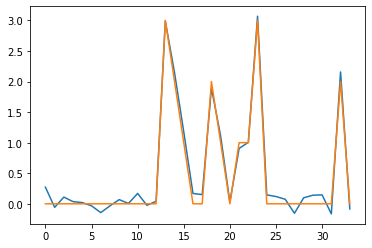

In [52]:
import matplotlib.pyplot as plt
plt.plot(df5[51102])
plt.plot(df4[51102])
plt.show()

In [54]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, LSTM, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [55]:
df = df5

In [117]:
target = 51102

In [118]:
shift_time = 1
shift_steps = shift_time * 1 

df_targets = df[target].shift(-shift_steps)

In [119]:
print(df_targets.tail())

date_block_num
29.0    0.145309
30.0   -0.165442
31.0    2.156632
32.0   -0.083777
33.0         NaN
Name: 51102, dtype: float64


In [120]:
x_data = df.values[0:-shift_steps]
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (33, 214200)


In [121]:
y_data = df_targets.values[:-shift_steps]

print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (33,)


In [122]:
num_data = len(x_data)
print(num_data)

33


In [123]:
train_split = 0.8

In [124]:
num_train = int(train_split * num_data)
print(num_train)

num_test = num_data - num_train
print(num_test)

26
7


In [125]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
print(len(x_train) + len(x_test))


y_train = y_data[0:num_train]
y_test = y_data[num_train:]
print(len(y_train) + len(y_test))

33
33


In [126]:
x_test

array([[ 0.13335698, -0.00913257,  0.0532113 , ...,  0.28440044,
         0.12513282, -0.07284941],
       [ 0.1079965 , -0.08114168, -0.04659654, ..., -0.16887047,
         0.03274957, -0.03748416],
       [ 1.11316043,  0.12111417,  2.9491988 , ...,  0.2388759 ,
        -0.04671523,  0.31926926],
       ...,
       [ 1.20376965,  0.13583722,  0.03126273, ..., -0.04920088,
        -0.03135796, -0.17905316],
       [ 3.10837143, -0.0743335 ,  0.91605552, ...,  0.19260391,
        -0.02032363,  0.05743809],
       [ 1.04327585, -0.17154087,  3.03964356, ...,  0.10762691,
         0.12637476,  0.05618182]])

In [127]:
num_x_signals = x_data.shape[1]
print(num_x_signals)

214200


In [128]:
num_y_signals = y_data.shape[0]
print(num_y_signals)

33
